In [1]:

# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [4]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [5]:

vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


In [8]:
data_index = 0


# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, context_window):
    # all context tokens should be used, hence no associated num_skips argument
    global data_index
    context_size = 2 * context_window
    batch = np.ndarray(shape=(batch_size, context_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * context_window + 1  # [ context_window target context_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size):
        # context tokens are just all the tokens in buffer except the target
        batch[i, :] = [token for idx, token in enumerate(buffer) if idx != context_window]
        labels[i, 0] = buffer[context_window]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels


batch, labels = generate_batch(batch_size=8, context_window=1)
for i in range(8):
    print(batch[i, 0], reverse_dictionary[batch[i, 0]],
          batch[i, 1], reverse_dictionary[batch[i, 1]],
          '->', labels[i, 0], reverse_dictionary[labels[i, 0]])


5239 anarchism 12 as -> 3084 originated
3084 originated 6 a -> 12 as
12 as 195 term -> 6 a
6 a 2 of -> 195 term
195 term 3137 abuse -> 2 of
2 of 46 first -> 3137 abuse
3137 abuse 59 used -> 46 first
46 first 156 against -> 59 used


In [25]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
context_window = 1  # How many words to consider left and right.
context_size = 2 * context_window

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64  # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():
    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size, context_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
        # take mean of embeddings of context words for context embedding
        embed_context = tf.reduce_mean(embed, 1)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
        tf.nn.nce_loss(nce_weights,nce_biases,train_labels,embed_context,num_sampled, vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [26]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
            batch_size, context_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = "Nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  271.909881592
Nearest to nine: cohabitation, hamburg, skates, ricimer, banks, bowstring, sacrum, exoskeleton,
Nearest to from: flavored, gebhard, slippage, chariot, seifert, attorney, danube, sinai,
Nearest to all: heisei, prosecuting, marshalling, drawer, mediawiki, halfbakery, enumerated, impressions,
Nearest to after: fanu, enmity, dimona, cleves, microlensing, corvus, spurious, everyone,
Nearest to they: predication, ardennes, emb, stumbling, flaming, wrigley, urbe, firepower,
Nearest to not: inverting, independant, beaches, resentment, repeatedly, graziani, longmans, deities,
Nearest to however: makeover, amniotic, estimation, caecilius, basses, recovery, hyperbole, depression,
Nearest to was: psychotherapy, islands, dependencies, curved, drawer, moraines, perutz, bezier,
Nearest to th: moved, hyperbole, making, beagle, sewage, cummings, gender, amendments,
Nearest to such: maginot, handily, stoiber, acknowledgement, shaivism, hygiene, admire

Nearest to th: six, rd, seven, making, haliotis, kilometers, nine, examine,
Nearest to such: well, dominoes, augustus, many, proponents, silica, including, prayer,
Nearest to other: grace, flew, shooting, pascal, contemporary, corruption, acquire, covert,
Nearest to also: never, carriers, still, often, mentions, oath, which, vii,
Nearest to s: coercion, starter, bovine, dahomey, phylogeny, his, reilly, wanted,
Nearest to for: using, ecological, main, dissent, korean, sharply, interim, implementations,
Nearest to an: lineman, journal, lipsius, summed, ustawa, ventures, longstreet, anchoring,
Nearest to its: their, the, his, her, physics, manor, allegro, camps,
Average loss at step  52000 :  4.63630103135
Average loss at step  54000 :  4.54203544211
Average loss at step  56000 :  4.46648556745
Average loss at step  58000 :  4.38246235931
Average loss at step  60000 :  4.42004847193
Nearest to nine: eight, seven, six, five, zero, four, ursus, beaked,
Nearest to from: chariot, including, i

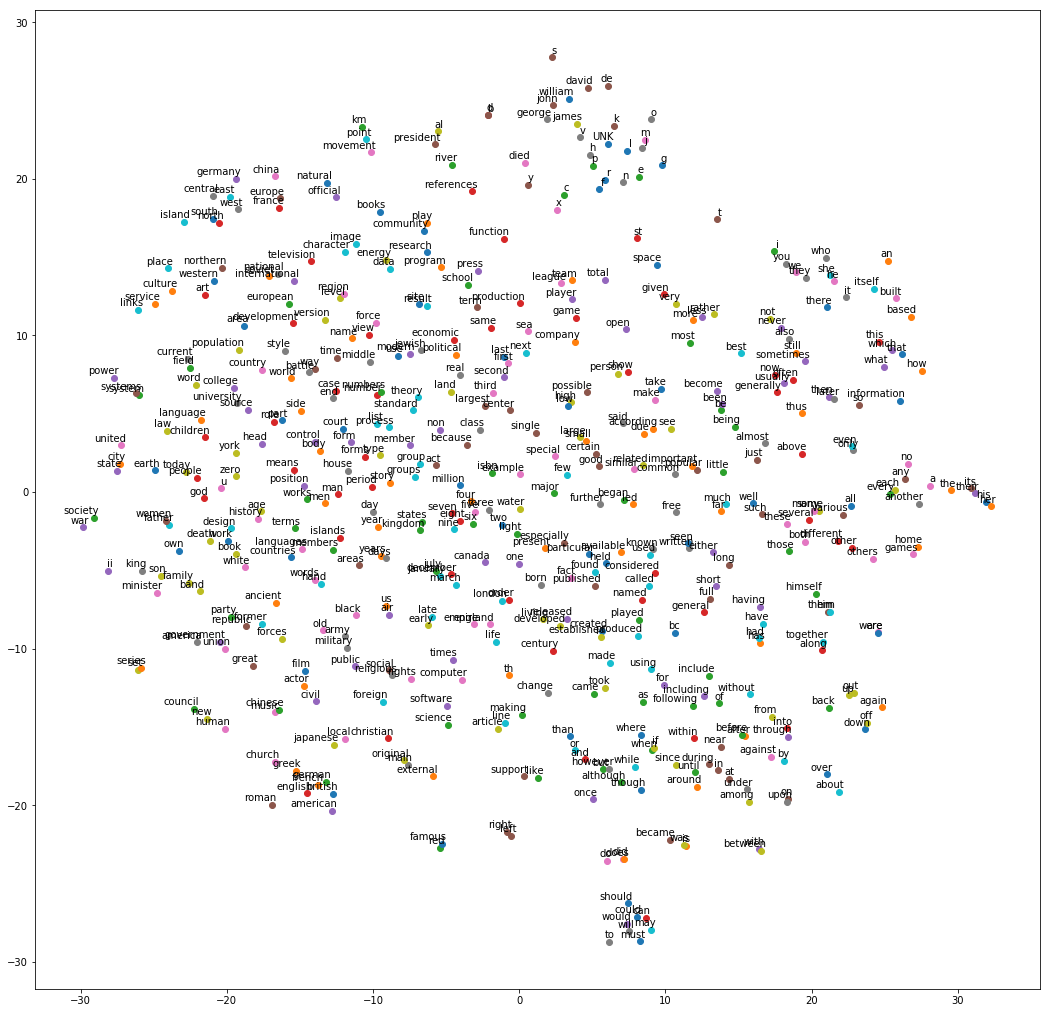

In [27]:
# Step 6: Visualize the embeddings.

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)


try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print("Please install sklearn and matplotlib to visualize embeddings.")